# Multilabel-multiclass

In [1]:
# For dataset.
from sklearn.datasets import make_multilabel_classification
from qiskit_algorithms.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

/var/folders/4z/946_ygn50p3bc_rsjbq9cg240000gn/T/ipykernel_78528/3375632282.py:4: DeprecationWarning: ``qiskit.algorithms`` has been migrated to an independent package: https://github.com/qiskit-community/qiskit-algorithms. The ``qiskit.algorithms`` import path is deprecated as of qiskit-terra 0.25.0 and will be removed no earlier than 3 months after the release date. Please run ``pip install qiskit_algorithms`` and use ``import qiskit_algorithms`` instead.
  from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

In [32]:
# for data split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [4]:
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap

In [5]:
X, y = make_multilabel_classification(
    n_samples=10000,
    n_features=2,
    n_classes=2,
    n_labels=2,
    # n_redundant=0,
    # n_clusters_per_class=1,
    # class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)

In [6]:
X.shape, y.shape

((10000, 2), (10000, 2))

In [7]:
y[:10] # = [3,1,2,0,2,3,3,3,3,3 ...]

array([[1, 0],
       [1, 1],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 1],
       [0, 1],
       [1, 1],
       [1, 1],
       [1, 1]])

In [8]:
## Train test split
train_features, test_features, train_labels, test_labels = train_test_split(
    X, y, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [9]:
train_labels_new = train_labels[:,0]*1+train_labels[:,1]*2

In [10]:
test_labels_new = test_labels[:,0]*1+test_labels[:,1]*2

In [11]:
train_labels_new[:10]

array([3, 3, 2, 1, 3, 3, 3, 3, 2, 1])

In [12]:
num_features = X.shape[1]

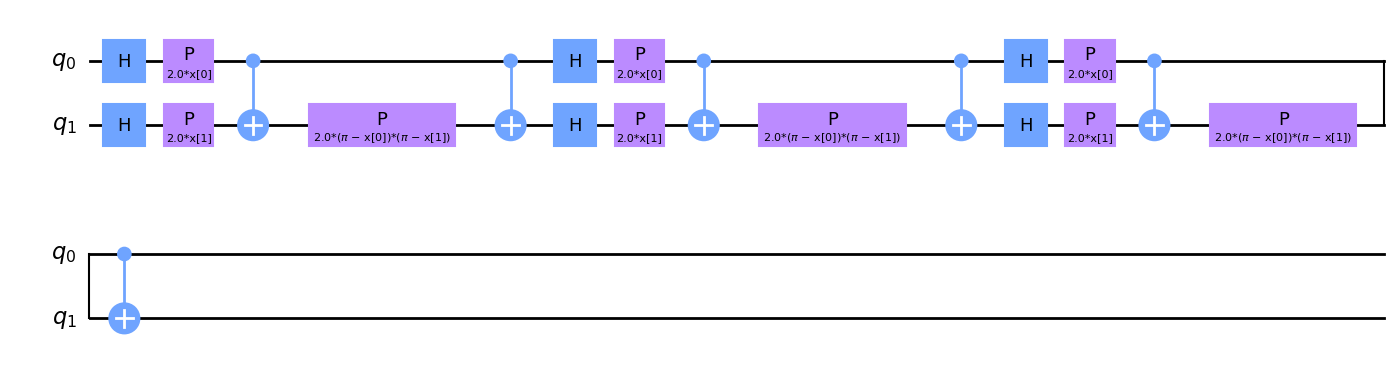

In [13]:
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=3)
feature_map.decompose().draw(output="mpl", fold=20)

In [14]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
# ansatz.decompose().draw(output="mpl", fold=20)

In [15]:
# defining the optimiser
optimizer = COBYLA(maxiter=100)

In [16]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

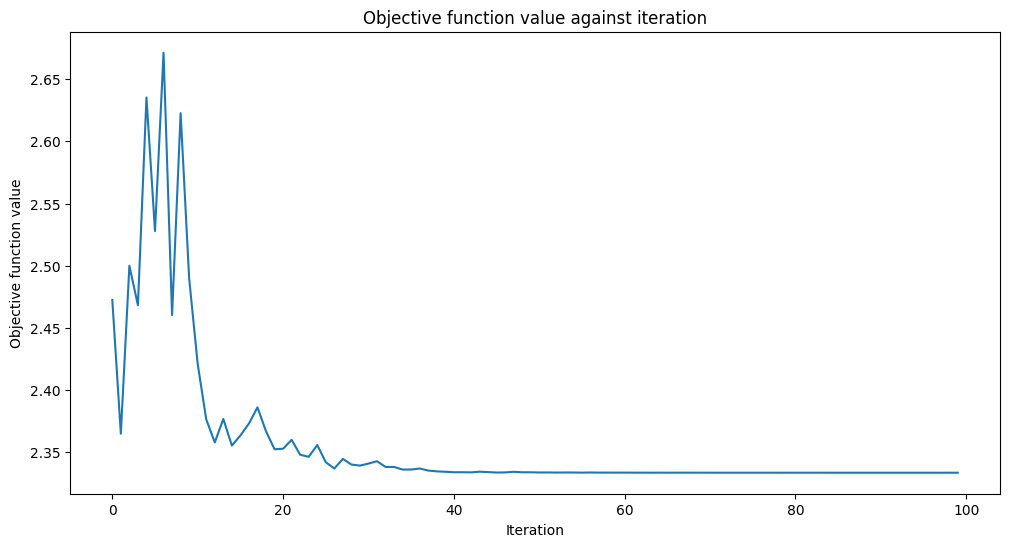

Training time: 1282 seconds


In [17]:
vqc = VQC(
    # sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    loss='cross_entropy',
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(train_features, train_labels_new)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [19]:
# testing the QSVC scores
train_score_q4 = vqc.score(train_features, train_labels_new)
test_score_q4 = vqc.score(test_features, test_labels_new)

print(f"Quantum VQC on the training dataset: {train_score_q4:.2f}")
print(f"Quantum VQC on the test dataset:     {test_score_q4:.2f}")

Quantum VQC on the training dataset: 0.34
Quantum VQC on the test dataset:     0.34


In [20]:
predictions = vqc.predict(test_features)

In [21]:
predictions[:20]

array([0, 2, 3, 0, 0, 3, 3, 3, 1, 3, 3, 3, 3, 1, 1, 3, 3, 1, 1, 3])

In [24]:
test_labels_new[:20]

array([0, 0, 3, 1, 3, 2, 3, 0, 0, 2, 3, 3, 3, 2, 3, 1, 0, 0, 3, 3])

In [29]:
predictions.shape

(2000,)

In [33]:
# Define the mapping
mapping = {0: [0, 0], 1: [1, 0], 2: [0, 1], 3: [1, 1]}

# Use list comprehension to create the new array
predictions_labels_final = np.array([mapping[val] for val in predictions])

print(predictions_labels_final[:5])

[[0 0]
 [0 1]
 [1 1]
 [0 0]
 [0 0]]


In [35]:
predictions_labels_final.shape

(2000, 2)

In [36]:
test_labels.shape

(2000, 2)

In [37]:
accuracy_score(predictions_labels_final, test_labels)

0.3405